In [1]:
import pandas as pd
import polars as pl
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
# could be problematic in future (ie. deprecations)
warnings.filterwarnings('ignore')

In [2]:
base_futures = pd.read_csv("C:/Users/tomco/OneDrive - UNSW/2024\FINS3666/top30_1hr.csv")
base_spot = pd.read_csv("C:/Users/tomco/OneDrive - UNSW/2024\FINS3666/top30_spot.csv")
funding = pd.read_csv("C:/Users/tomco/OneDrive - UNSW/2024\FINS3666/top30_funding.csv")

# renaming columns
base_futures.columns = ['open_timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_timestamp', 'quote_volume', 'count', 'taker_buy_volume', 'taker_quote_volume', 'ignore', 'ticker']
# selecting OHLC data and other relevant information
base_futures = base_futures.drop(columns = ['close_timestamp', 'taker_buy_volume', 'taker_quote_volume', 'ignore'])

# renaming columns
base_spot.columns = ['row_names', 'open_timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_timestamp', 'quote_volume', 'count', 'taker_buy_volume', 'taker_quote_volume', 'ignore', 'ticker']
# selecting OHLC data and other relevant information
base_spot = base_spot.drop(columns = ['close_timestamp', 'taker_buy_volume', 'taker_quote_volume', 'ignore'])

# extracting timestamp, price and ticker data
futures = base_futures[['open_timestamp', 'open', 'ticker']]
spot = base_spot[['open_timestamp', 'open', 'ticker']]

# reformatting funding columns
funding.columns = ['row_names', 'open_timestamp', 'funding_interval', 'rate', 'ticker']
funding = funding.drop(columns = 'row_names')
funding['open_timestamp'] = np.round(funding['open_timestamp'] / 1000) * 1000

In [3]:
funding['open_timestamp'] = pd.to_datetime(funding['open_timestamp'], unit='ms')
funding.set_index('open_timestamp', inplace=True)
daily_sum = funding.groupby('ticker').resample('D').sum()['rate'].reset_index()

# pivot from wide to long dataframe
daily_funding = daily_sum.pivot(index='open_timestamp', columns='ticker', values='rate').fillna(0)

futures_long = futures.pivot(index = 'open_timestamp',
                    columns = 'ticker',
                    values = 'open')
futures_long.index = pd.to_datetime(futures_long.index, unit = 'ms')

spot_long = spot.pivot(index = 'open_timestamp',
                    columns = 'ticker',
                    values = 'open')
spot_long.index = pd.to_datetime(spot_long.index, unit = 'ms')

spot_long = spot_long[spot_long.index >= pd.to_datetime('2020-01-01')]

# convert futures to daily
futures_long = futures_long[futures_long.index.time == pd.Timestamp('00:00:00').time()]


In [4]:
funding_averages = daily_funding.rolling(7, min_periods = 1).mean().fillna(0)

In [5]:
common_assets = spot_long.columns.intersection(futures_long.columns)

spot_long = spot_long[common_assets]
futures_long = futures_long[common_assets]

funding_daily = 0.1095 / 365
futures_pct = futures_long.pct_change()
spot_pct = spot_long.pct_change()

funding_sum = daily_funding[common_assets]

In [6]:
# CALCULATING WEIGHTS
# NOTE: POSITIVE WEIGHT MEANS SHORT PERP, LONG SPOT
weights = pd.DataFrame(index=funding_averages.index, columns=funding_averages.columns)

# Calculate weights
for date in funding_averages.index:
    if date.weekday() == 0:  # Check if the day is Monday
        # Initialize the daily weights to zero
        daily_weights = pd.Series(0, index=funding_averages.columns)
        
        for asset in futures_pct.columns:
            # Check if there are at least 5 periods of futures returns for this asset
            if futures_pct[asset].loc[:date].dropna().shape[0] >= 28:
                # Filter out zero observations for the day
                daily_rates = funding_averages.loc[date]
                non_zero_rates = daily_rates[daily_rates != 0]
                num_non_zero = len(non_zero_rates)
                
                # Calculate the top and bottom quartiles
                top_quartile = non_zero_rates[non_zero_rates > non_zero_rates.quantile(0.75)]
                bottom_quartile = non_zero_rates[non_zero_rates < non_zero_rates.quantile(0.25)]
                
                # Assign weights for the top quartile
                for asset in top_quartile.index:
                    daily_weights[asset] = 0.25 * num_non_zero * 0.5
                
                # Assign weights for the bottom quartile (if they are negative)
                #for asset in bottom_quartile.index:
                #    if bottom_quartile[asset] < 0:
                #        daily_weights[asset] = -0.25 * num_non_zero * 0.5
        
        # Apply the weights from Monday to the following Sunday
        for i in range(7):
            if date + pd.Timedelta(days=i) in weights.index:
                weights.loc[date + pd.Timedelta(days=i)] = daily_weights

# Forward fill the weights to ensure all days get Monday's weights
weights = weights.ffill().fillna(0)

# Scale weights such that the sum of the absolute value of weights for each row is equal to 1
for date in weights.index:
    abs_sum = weights.loc[date].abs().sum()
    if abs_sum != 0:
        weights.loc[date] = weights.loc[date] / abs_sum

spot_weights = weights
perp_weights = -weights

In [7]:
# Constructing Spot Portfolio
spot_nofees_rets = (spot_pct * spot_weights.shift(1)).sum(axis = 1)
#spot_nofees_cumulative = (1 + spot_nofees_rets).cumprod() - 1

# Constructing the Futures Portfolio
futures_nofees_rets = (futures_pct * perp_weights.shift(1)).sum(axis = 1)
#futures_nofees_cumulative = (1 + futures_nofees_rets).cumprod() - 1

# Basis Portfolio
# Method 1
basis_nofees_rets = spot_nofees_rets + futures_nofees_rets
basis_nofees_cumulative = (1 + basis_nofees_rets).cumprod() - 1

# Funding Accumulation
funding_rets = (funding_sum * spot_weights.shift(1)).sum(axis = 1) # because shorts get paid with positive
funding_cumulative = (1 + funding_rets).cumprod() - 1

# Portfolio Returns
portfolio_nofees_rets = basis_nofees_rets + funding_rets
portfolio_nofees_cumulative = (1 + portfolio_nofees_rets).cumprod() - 1

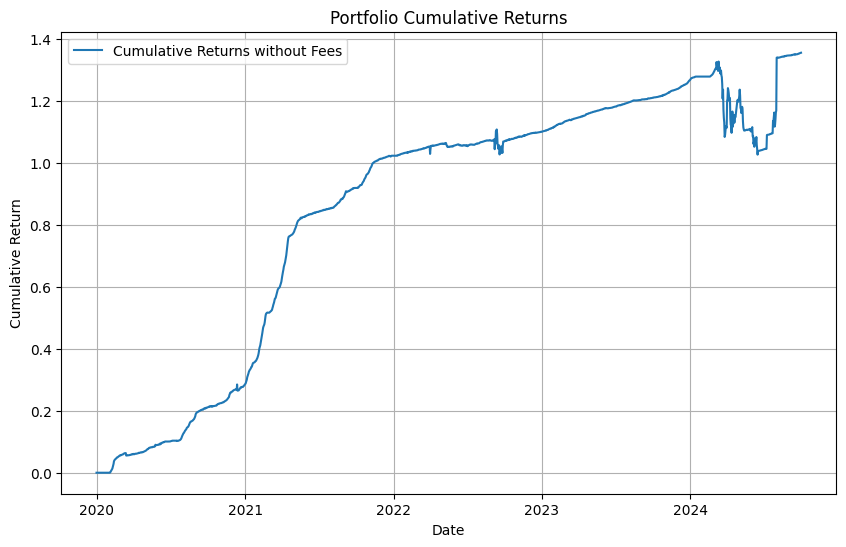

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_nofees_cumulative, label='Cumulative Returns without Fees')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True)

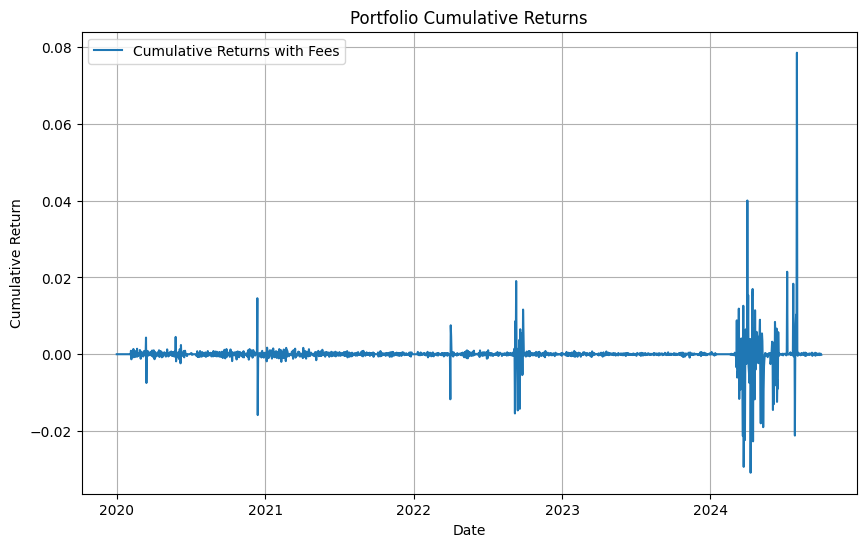

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(basis_nofees_rets, label='Cumulative Returns with Fees')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True)

In [10]:
neutral_check = spot_weights + perp_weights
neutral_check.sum(axis=1) == 0

open_timestamp
2020-01-01    True
2020-01-02    True
2020-01-03    True
2020-01-04    True
2020-01-05    True
              ... 
2024-09-26    True
2024-09-27    True
2024-09-28    True
2024-09-29    True
2024-09-30    True
Length: 1735, dtype: bool

In [34]:
initial_value = 100
fee = 0.0005
portfolio_values = pd.Series(index=spot_pct.index)
portfolio_values.iloc[0] = initial_value

# Initialize DataFrames to store dollar weights
dollar_weights_spot = pd.DataFrame(index=spot_weights.index, columns=spot_weights.columns)
dollar_weights_perp = pd.DataFrame(index=perp_weights.index, columns=perp_weights.columns)

for member in tqdm(range(1, len(portfolio_nofees_rets))):
    # Calculate current value of portfolio
    current_value = portfolio_values.iloc[member - 1] * (1 + portfolio_nofees_rets[member])
    
    # Calculate dollar weights for spot and perp
    dollar_weights_spot.iloc[member] = current_value * spot_weights.iloc[member]
    dollar_weights_perp.iloc[member] = current_value * perp_weights.iloc[member]
    
    # Calculate number of units held for spot and perp
    units_held_spot = dollar_weights_spot.div(spot_long.shift(1)).fillna(0)
    units_held_perp = dollar_weights_perp.div(futures_long.shift(1)).fillna(0)
    
    # Calculate the change in units held for spot and perp
    diff_units_held_spot = units_held_spot.diff().abs()
    diff_units_held_perp = units_held_perp.diff().abs()
    
    # Calculate transaction cost for spot and perp
    tx_cost_spot = diff_units_held_spot.mul(spot_long).sum(axis=1).iloc[member] * fee
    tx_cost_perp = diff_units_held_perp.mul(futures_long).sum(axis=1).iloc[member] * fee
    
    # Subtract transaction cost from current portfolio value
    total_tx_cost = tx_cost_spot + tx_cost_perp
    new_value = current_value - total_tx_cost
    
    # Store the new portfolio value
    portfolio_values.iloc[member] = new_value

100%|██████████| 1734/1734 [01:32<00:00, 18.80it/s]


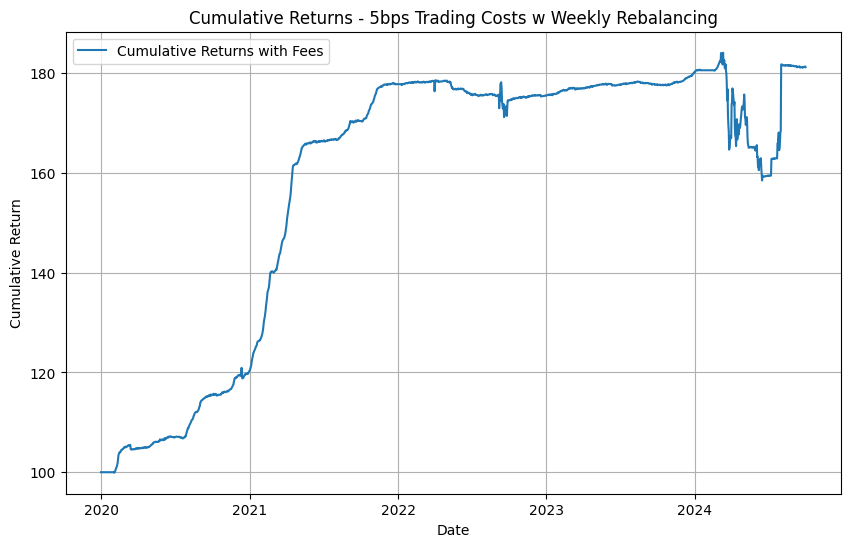

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Cumulative Returns with Fees')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns - 5bps Trading Costs w Weekly Rebalancing')
plt.legend()
plt.grid(True)

In [36]:
portfolio_full_rets = portfolio_values.pct_change()
portfolio_full_cumulative = (1 + portfolio_full_rets).cumprod() - 1

In [37]:
portfolio_values.tail()

open_timestamp
2024-09-26    181.199204
2024-09-27    181.228432
2024-09-28    181.267195
2024-09-29    181.322482
2024-09-30    181.181320
dtype: float64

In [39]:
print(portfolio_full_cumulative.tail())
portfolio_full_rets.std() * np.sqrt(365)

open_timestamp
2024-09-26    0.811992
2024-09-27    0.812284
2024-09-28    0.812672
2024-09-29    0.813225
2024-09-30    0.811813
dtype: float64


np.float64(0.0673408243509548)

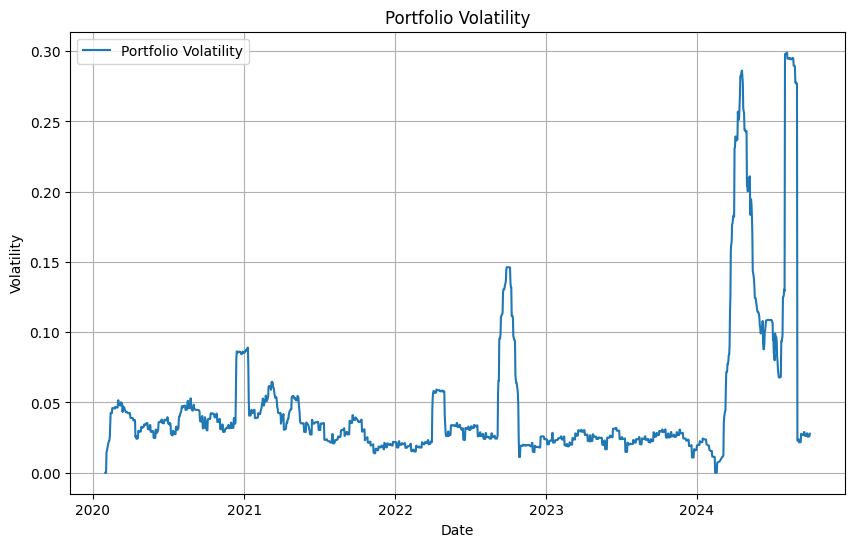

In [15]:

plt.figure(figsize=(10, 6))
plt.plot(portfolio_full_rets.rolling(30).std() * np.sqrt(365), label='Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Portfolio Volatility')
plt.legend()
plt.grid(True)